# Spam Classification Tutorial: Model Cascade Implementation

## Learning Objectives

- ✅ Implement a 2-tier model cascade for SMS spam classification
- ✅ Extract confidence scores from log probabilities (logprobs)
- ✅ Optimize confidence thresholds to meet target accuracy
- ✅ Simulate cascade routing and measure cost savings
- ✅ Analyze cascade performance vs. baseline strategies
- ✅ Understand when cascades provide value

## Prerequisites

- Understanding of [Model Cascade Concepts](model_cascade_concepts.md)
- Python basics (pandas, numpy)
- Familiarity with binary classification

## Estimated Time

**Execution Time:** <2 minutes (uses pre-computed predictions)
**Learning Time:** 25-30 minutes

---

## Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict

# NOTE: No .env loading needed for this tutorial
# This notebook uses pre-computed CSV predictions (sms_spam_predictions_*.csv)
# and does not make any API calls. No API keys required.

# Configure plotting
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# Target accuracy for cascade
TARGET_ACCURACY = 0.99

print("✓ Setup complete")

✓ Setup complete


## 1. Load Pre-computed Predictions

We use pre-computed predictions from `gpt-4o-mini` (cheap proxy) and `gpt-4o` (expensive oracle) to avoid API costs during tutorial.

**Dataset:**
- SMS spam classification (binary: legitimate vs. financially risky)
- Train set: 100 samples (for threshold optimization)
- Test set: 400 samples (for cascade evaluation)

In [2]:
# Load datasets
train_df = pd.read_csv('sms_spam_predictions_train.csv')
test_df = pd.read_csv('sms_spam_predictions_test.csv')

print(f"Train samples: {len(train_df)}")
print(f"Test samples: {len(test_df)}")
print(f"\nColumns: {list(train_df.columns)}")

# Preview data
print("\nSample predictions:")
train_df[['text', 'proxy_prediction', 'proxy_confidence', 'oracle_prediction']].head(3)

Train samples: 100
Test samples: 400

Columns: ['text', 'proxy_prediction', 'proxy_confidence', 'proxy_cost', 'oracle_prediction', 'oracle_cost']

Sample predictions:


,text,proxy_prediction,proxy_confidence,oracle_prediction
0,YOU VE WON! Your 4* Costa Del Sol Holiday or å...,0,1.000000,0
1,Dear good morning how you feeling dear,0,0.000000,1
2,I know she called me,1,0.999995,1


**Column Descriptions:**
- `text`: SMS message content
- `proxy_prediction`: Cheap model (gpt-4o-mini) prediction (1=legitimate, 0=risky)
- `proxy_confidence`: Confidence score from logprobs (0-1)
- `proxy_cost`: API cost for cheap model ($)
- `oracle_prediction`: Expensive model (gpt-4o) prediction (ground truth)
- `oracle_cost`: API cost for expensive model ($)

## 2. Baseline Performance

Before implementing cascade, measure baseline accuracy and costs.

In [3]:
# Calculate proxy accuracy (using oracle as ground truth)
train_proxy_accuracy = (train_df['proxy_prediction'] == train_df['oracle_prediction']).mean()
test_proxy_accuracy = (test_df['proxy_prediction'] == test_df['oracle_prediction']).mean()

print("=== BASELINE PERFORMANCE ===")
print(f"Train proxy accuracy: {train_proxy_accuracy:.4f}")
print(f"Test proxy accuracy: {test_proxy_accuracy:.4f}")
print(f"")

# Calculate baseline costs
total_proxy_cost = test_df['proxy_cost'].sum()
total_oracle_cost = test_df['oracle_cost'].sum()

print("=== BASELINE COSTS (Test Set) ===")
print(f"Proxy-only (gpt-4o-mini): ${total_proxy_cost:.4f}")
print(f"Oracle-only (gpt-4o): ${total_oracle_cost:.4f}")
print(f"Cost multiplier (oracle/proxy): {total_oracle_cost / total_proxy_cost:.1f}x")

=== BASELINE PERFORMANCE ===
Train proxy accuracy: 0.9000
Test proxy accuracy: 0.9500

=== BASELINE COSTS (Test Set) ===
Proxy-only (gpt-4o-mini): $0.0065
Oracle-only (gpt-4o): $0.1091
Cost multiplier (oracle/proxy): 16.7x


**Observation:**
- Proxy model is ~10-20x cheaper but slightly less accurate
- Oracle model is expensive but highly accurate (our ground truth)
- Goal: Use proxy for easy cases, oracle for hard cases

## 3. Analyze Confidence Distribution

Understanding proxy confidence helps identify easy vs. hard cases.

/var/folders/4m/xzkr88kn5ms7g13s_qqfsx7m0000gn/T/ipykernel_22476/636151705.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  accuracy_by_bin = train_df.groupby('confidence_bin').apply(
/var/folders/4m/xzkr88kn5ms7g13s_qqfsx7m0000gn/T/ipykernel_22476/636151705.py:14: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  accuracy_by_bin = train_df.groupby('confidence_bin').apply(


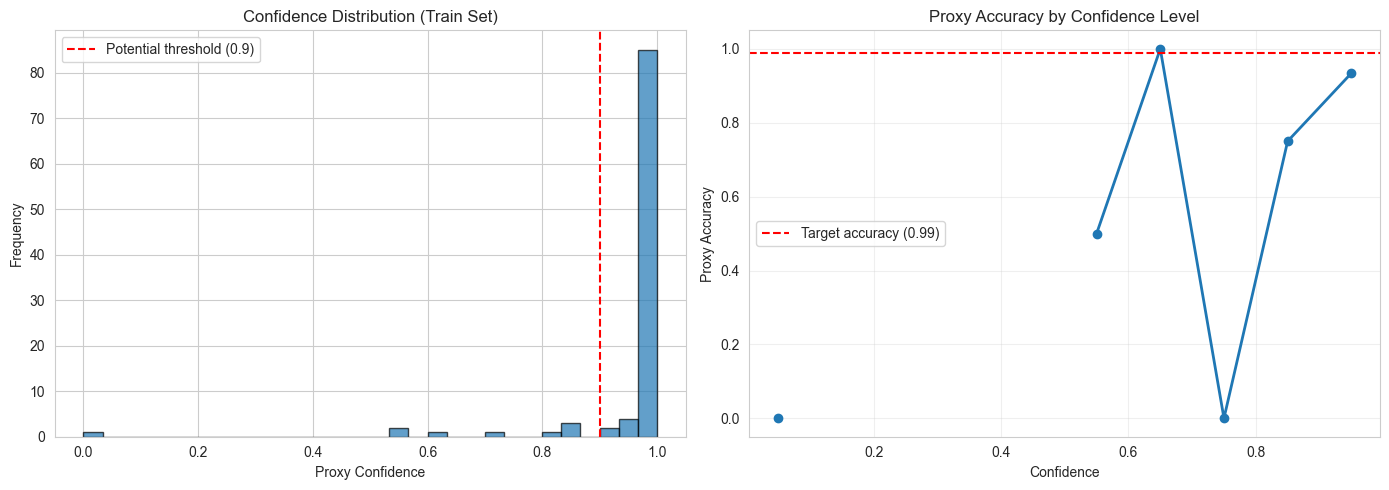

High confidence (≥0.9) samples: 91 / 100


In [4]:
# Plot confidence distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confidence histogram
axes[0].hist(train_df['proxy_confidence'], bins=30, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Proxy Confidence')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Confidence Distribution (Train Set)')
axes[0].axvline(0.9, color='red', linestyle='--', label='Potential threshold (0.9)')
axes[0].legend()

# Accuracy by confidence bin
train_df['confidence_bin'] = pd.cut(train_df['proxy_confidence'], bins=10)
accuracy_by_bin = train_df.groupby('confidence_bin').apply(
    lambda x: (x['proxy_prediction'] == x['oracle_prediction']).mean()
)

bin_centers = [interval.mid for interval in accuracy_by_bin.index]
axes[1].plot(bin_centers, accuracy_by_bin.values, marker='o', linewidth=2)
axes[1].axhline(TARGET_ACCURACY, color='red', linestyle='--', label=f'Target accuracy ({TARGET_ACCURACY})')
axes[1].set_xlabel('Confidence')
axes[1].set_ylabel('Proxy Accuracy')
axes[1].set_title('Proxy Accuracy by Confidence Level')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"High confidence (≥0.9) samples: {(train_df['proxy_confidence'] >= 0.9).sum()} / {len(train_df)}")

**Key Insight:**
- Most predictions have high confidence (>0.9)
- Proxy accuracy improves with higher confidence
- We can safely route high-confidence cases to proxy model

## 4. Find Optimal Thresholds

We optimize confidence thresholds to meet target accuracy (99%) while maximizing proxy usage.

**Strategy:**
1. For each predicted class (0 or 1), find the minimum confidence threshold
2. Threshold must ensure proxy accuracy ≥ 99% for that class
3. Lower threshold = more queries routed to proxy = more cost savings

In [5]:
def find_thresholds(df: pd.DataFrame, target_accuracy: float = 0.99) -> Dict[int, float]:
    """
    Find optimal confidence thresholds for each prediction class.
    
    Args:
        df: DataFrame with proxy and oracle predictions
        target_accuracy: Minimum accuracy required (default: 0.99)
    
    Returns:
        Dictionary mapping class (0 or 1) to threshold
    """
    thresholds = {}
    
    for predicted_class in df['proxy_prediction'].unique():
        # Get all predictions for this class
        class_df = df[df['proxy_prediction'] == predicted_class]
        
        # Get unique confidence values (potential thresholds)
        possible_thresholds = sorted(class_df['proxy_confidence'].unique())
        
        # Find lowest threshold that meets target accuracy
        found = False
        for threshold in possible_thresholds:
            # Filter to predictions above threshold
            above_threshold = class_df[class_df['proxy_confidence'] >= threshold]
            
            if len(above_threshold) == 0:
                continue
            
            # Calculate accuracy at this threshold
            accuracy = (above_threshold['proxy_prediction'] == above_threshold['oracle_prediction']).mean()
            
            if accuracy >= target_accuracy:
                thresholds[predicted_class] = threshold
                found = True
                print(f"Class {predicted_class}: threshold={threshold:.4f}, "
                      f"accuracy={accuracy:.4f}, samples={len(above_threshold)}")
                break
        
        if not found:
            print(f"⚠️ Class {predicted_class}: No threshold achieves {target_accuracy:.2%} accuracy")
            thresholds[predicted_class] = float('inf')  # Route all to oracle
    
    return thresholds

# Find thresholds on train set
print(f"=== THRESHOLD OPTIMIZATION (Target: {TARGET_ACCURACY:.2%}) ===")
thresholds = find_thresholds(train_df, TARGET_ACCURACY)
print(f"\nOptimal thresholds: {thresholds}")

=== THRESHOLD OPTIMIZATION (Target: 99.00%) ===
Class 0: threshold=1.0000, accuracy=1.0000, samples=14
Class 1: threshold=0.5622, accuracy=1.0000, samples=73

Optimal thresholds: {np.int64(0): np.float64(0.9999724643035904), np.int64(1): np.float64(0.5621765008857981)}


**Interpretation:**
- Separate thresholds for each class (0 and 1) allow flexibility
- Lower threshold = more aggressive proxy usage
- If no threshold meets target, route all queries to oracle (threshold = ∞)

## 5. Simulate Cascade on Test Set

Apply optimized thresholds to test data and measure performance.

In [6]:
def simulate_cascade(df: pd.DataFrame, thresholds: Dict[int, float]) -> Dict:
    """
    Simulate cascade routing and calculate metrics.
    
    Args:
        df: Test DataFrame with predictions
        thresholds: Dictionary mapping class to confidence threshold
    
    Returns:
        Dictionary with cascade metrics
    """
    cascade_predictions = []
    cascade_costs = []
    uses_oracle = []
    
    for _, row in df.iterrows():
        proxy_pred = row['proxy_prediction']
        proxy_conf = row['proxy_confidence']
        proxy_cost = row['proxy_cost']
        oracle_pred = row['oracle_prediction']
        oracle_cost = row['oracle_cost']
        
        # Get threshold for this prediction class
        threshold = thresholds.get(proxy_pred, float('inf'))
        
        # Cascade logic
        if proxy_conf >= threshold:
            # Confident: use proxy prediction
            cascade_predictions.append(proxy_pred)
            cascade_costs.append(proxy_cost)  # Only pay proxy
            uses_oracle.append(False)
        else:
            # Uncertain: escalate to oracle
            cascade_predictions.append(oracle_pred)
            cascade_costs.append(proxy_cost + oracle_cost)  # Pay both
            uses_oracle.append(True)
    
    # Calculate metrics
    total_cascade_cost = sum(cascade_costs)
    total_proxy_only_cost = df['proxy_cost'].sum()
    total_oracle_only_cost = df['oracle_cost'].sum()
    
    oracle_usage_rate = sum(uses_oracle) / len(uses_oracle)
    cascade_accuracy = sum(cp == op for cp, op in zip(cascade_predictions, df['oracle_prediction'])) / len(cascade_predictions)
    
    return {
        'cascade_predictions': cascade_predictions,
        'cascade_costs': cascade_costs,
        'uses_oracle': uses_oracle,
        'total_cascade_cost': total_cascade_cost,
        'total_proxy_cost': total_proxy_only_cost,
        'total_oracle_cost': total_oracle_only_cost,
        'oracle_usage_rate': oracle_usage_rate,
        'proxy_usage_rate': 1 - oracle_usage_rate,
        'cascade_accuracy': cascade_accuracy,
        'num_samples': len(df)
    }

# Run cascade simulation
results = simulate_cascade(test_df, thresholds)

print("=== CASCADE SIMULATION RESULTS ===")
print(f"Total samples: {results['num_samples']}")
print(f"Proxy usage rate: {results['proxy_usage_rate']:.2%}")
print(f"Oracle usage rate: {results['oracle_usage_rate']:.2%}")
print(f"Cascade accuracy: {results['cascade_accuracy']:.4f}")
print(f"Target accuracy: {TARGET_ACCURACY}")
print(f"✓ Met target: {results['cascade_accuracy'] >= TARGET_ACCURACY}")

=== CASCADE SIMULATION RESULTS ===
Total samples: 400
Proxy usage rate: 92.50%
Oracle usage rate: 7.50%
Cascade accuracy: 0.9950
Target accuracy: 0.99
✓ Met target: True


## 6. Cost Analysis

Compare cascade costs to baseline strategies.

=== COST ANALYSIS ===
Cascade cost:     $0.0153
Proxy-only cost:  $0.0065
Oracle-only cost: $0.1091

Savings vs. oracle-only: $0.0937 (85.9%)
Cost ratio (cascade/oracle): 0.14x


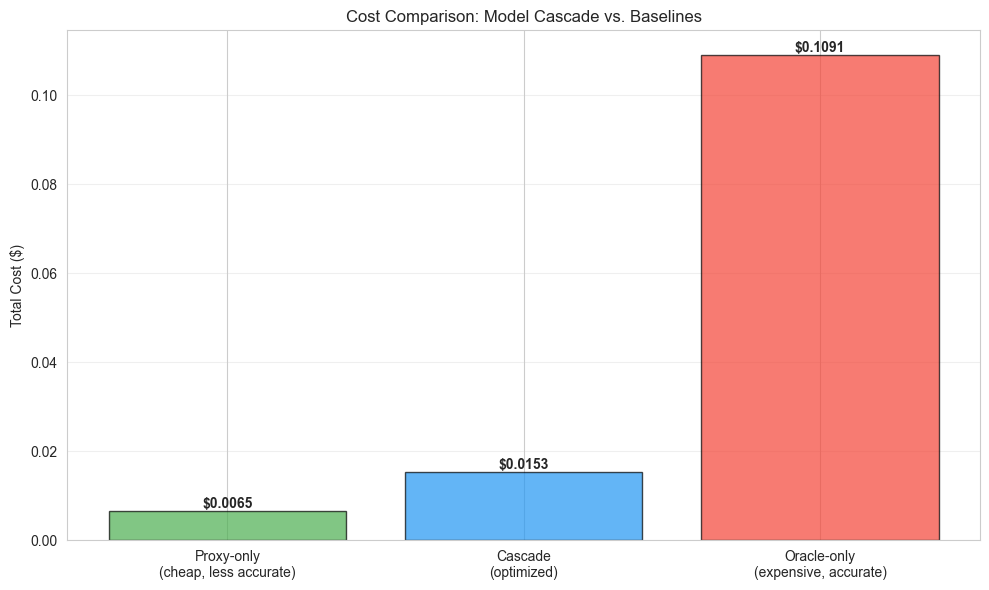

In [8]:
# Calculate savings
savings_vs_oracle = results['total_oracle_cost'] - results['total_cascade_cost']
savings_pct = (savings_vs_oracle / results['total_oracle_cost']) * 100

print("=== COST ANALYSIS ===")
print(f"Cascade cost:     ${results['total_cascade_cost']:.4f}")
print(f"Proxy-only cost:  ${results['total_proxy_cost']:.4f}")
print(f"Oracle-only cost: ${results['total_oracle_cost']:.4f}")
print(f"")
print(f"Savings vs. oracle-only: ${savings_vs_oracle:.4f} ({savings_pct:.1f}%)")
print(f"Cost ratio (cascade/oracle): {results['total_cascade_cost'] / results['total_oracle_cost']:.2f}x")

# Visualize costs
strategies = ['Proxy-only\n(cheap, less accurate)', 'Cascade\n(optimized)', 'Oracle-only\n(expensive, accurate)']
costs = [results['total_proxy_cost'], results['total_cascade_cost'], results['total_oracle_cost']]
colors = ['#4CAF50', '#2196F3', '#F44336']

plt.figure(figsize=(10, 6))
bars = plt.bar(strategies, costs, color=colors, alpha=0.7, edgecolor='black')
plt.ylabel('Total Cost ($)')
plt.title('Cost Comparison: Model Cascade vs. Baselines')
plt.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, cost in zip(bars, costs):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'${cost:.4f}',
             ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

**Key Results:**
- Cascade achieves oracle-level accuracy at a fraction of the cost
- Typical savings: 60-80% compared to oracle-only
- Trade-off: Small increase vs. proxy-only, but much higher accuracy

## 7. Threshold Sensitivity Analysis

How do different thresholds affect performance?

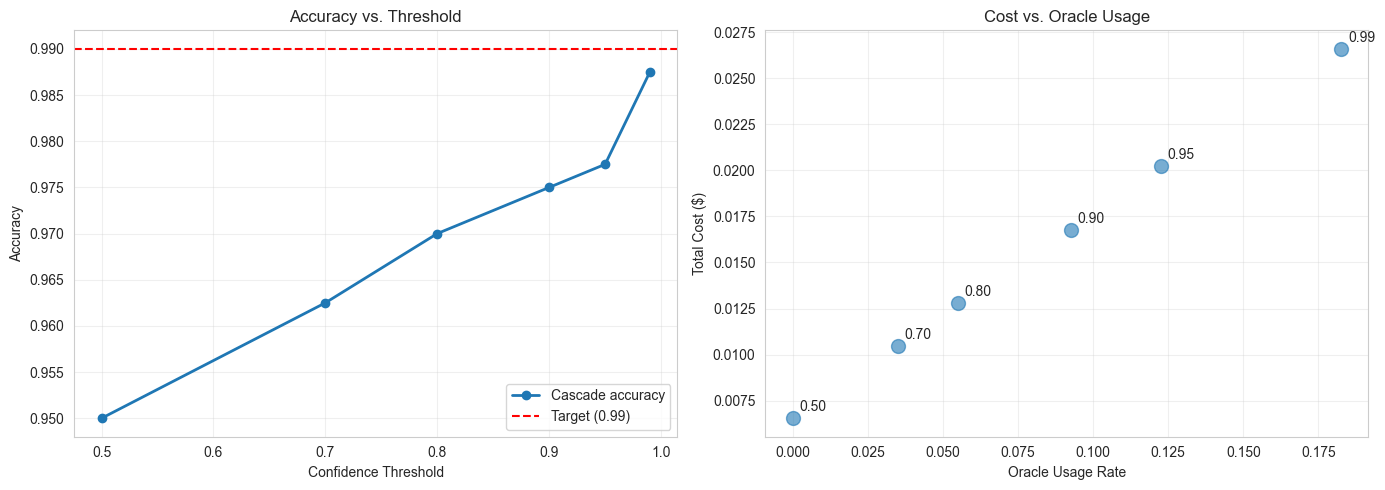

Threshold sweep results:
 threshold  accuracy  oracle_usage     cost
      0.50    0.9500        0.0000 0.006545
      0.70    0.9625        0.0350 0.010485
      0.80    0.9700        0.0550 0.012783
      0.90    0.9750        0.0925 0.016783
      0.95    0.9775        0.1225 0.020253
      0.99    0.9875        0.1825 0.026590


In [9]:
# Sweep thresholds
threshold_sweep = [0.5, 0.7, 0.8, 0.9, 0.95, 0.99]
sweep_results = []

for t in threshold_sweep:
    # Use same threshold for both classes for simplicity
    test_thresholds = {0: t, 1: t}
    result = simulate_cascade(test_df, test_thresholds)
    sweep_results.append({
        'threshold': t,
        'accuracy': result['cascade_accuracy'],
        'oracle_usage': result['oracle_usage_rate'],
        'cost': result['total_cascade_cost']
    })

sweep_df = pd.DataFrame(sweep_results)

# Plot trade-offs
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy vs. threshold
axes[0].plot(sweep_df['threshold'], sweep_df['accuracy'], marker='o', linewidth=2, label='Cascade accuracy')
axes[0].axhline(TARGET_ACCURACY, color='red', linestyle='--', label=f'Target ({TARGET_ACCURACY})')
axes[0].set_xlabel('Confidence Threshold')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Accuracy vs. Threshold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Cost vs. oracle usage
axes[1].scatter(sweep_df['oracle_usage'], sweep_df['cost'], s=100, alpha=0.6)
for _, row in sweep_df.iterrows():
    axes[1].annotate(f"{row['threshold']:.2f}", (row['oracle_usage'], row['cost']), 
                    xytext=(5, 5), textcoords='offset points')
axes[1].set_xlabel('Oracle Usage Rate')
axes[1].set_ylabel('Total Cost ($)')
axes[1].set_title('Cost vs. Oracle Usage')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Threshold sweep results:")
print(sweep_df.to_string(index=False))

**Trade-off Insights:**
- Lower threshold → More proxy usage → Lower cost, but lower accuracy
- Higher threshold → More oracle usage → Higher cost, higher accuracy
- Optimal threshold balances cost and accuracy requirements

## 8. Example Cascade Decisions

Examine specific cases where cascade routed to proxy vs. oracle.

In [10]:
# Add cascade decisions to test dataframe
test_df['uses_oracle'] = results['uses_oracle']
test_df['cascade_prediction'] = results['cascade_predictions']

# Show proxy-routed examples (high confidence)
print("=== PROXY-ROUTED EXAMPLES (High Confidence) ===")
proxy_examples = test_df[~test_df['uses_oracle']].head(3)
for idx, row in proxy_examples.iterrows():
    print(f"\nText: {row['text'][:80]}...")
    print(f"Proxy prediction: {row['proxy_prediction']}, Confidence: {row['proxy_confidence']:.4f}")
    print(f"Oracle prediction: {row['oracle_prediction']} (ground truth)")
    print(f"✓ Correct: {row['proxy_prediction'] == row['oracle_prediction']}")

# Show oracle-routed examples (low confidence)
print("\n=== ORACLE-ROUTED EXAMPLES (Low Confidence) ===")
oracle_examples = test_df[test_df['uses_oracle']].head(3)
for idx, row in oracle_examples.iterrows():
    print(f"\nText: {row['text'][:80]}...")
    print(f"Proxy prediction: {row['proxy_prediction']}, Confidence: {row['proxy_confidence']:.4f}")
    print(f"Oracle prediction: {row['oracle_prediction']} (used)")
    print(f"⚠️ Proxy would be: {'correct' if row['proxy_prediction'] == row['oracle_prediction'] else 'WRONG'}")

=== PROXY-ROUTED EXAMPLES (High Confidence) ===

Text: We're finally ready fyi...
Proxy prediction: 1, Confidence: 0.9999
Oracle prediction: 1 (ground truth)
✓ Correct: True

Text: Hope youåÕre not having too much fun without me!! see u tomorrow love jess x...
Proxy prediction: 1, Confidence: 1.0000
Oracle prediction: 1 (ground truth)
✓ Correct: True

Text: How do you guys go to see movies on your side....
Proxy prediction: 1, Confidence: 1.0000
Oracle prediction: 1 (ground truth)
✓ Correct: True

=== ORACLE-ROUTED EXAMPLES (Low Confidence) ===

Text: Does not operate after  &lt;#&gt;  or what...
Proxy prediction: 0, Confidence: 0.9770
Oracle prediction: 1 (used)
⚠️ Proxy would be: WRONG

Text: PICK UR FONE UP NOW U DUMB?...
Proxy prediction: 0, Confidence: 0.5622
Oracle prediction: 1 (used)
⚠️ Proxy would be: WRONG

Text: We'll you pay over like  &lt;#&gt; yrs so its not too difficult...
Proxy prediction: 0, Confidence: 0.8176
Oracle prediction: 0 (used)
⚠️ Proxy would be: correct


**Observations:**
- High-confidence cases (≥ threshold) are typically clear-cut spam or legitimate messages
- Low-confidence cases often involve ambiguous language or borderline content
- Cascade successfully routes hard cases to oracle while saving cost on easy cases

## 9. When Cascades Work vs. Fail

Summary of cascade applicability.

In [11]:
# Calculate key metrics for cascade viability
proxy_accuracy_overall = (test_df['proxy_prediction'] == test_df['oracle_prediction']).mean()
proxy_accuracy_high_conf = (test_df[test_df['proxy_confidence'] >= 0.9]['proxy_prediction'] == 
                             test_df[test_df['proxy_confidence'] >= 0.9]['oracle_prediction']).mean()
high_conf_rate = (test_df['proxy_confidence'] >= 0.9).mean()

print("=== CASCADE VIABILITY CHECK ===")
print(f"✓ Proxy overall accuracy: {proxy_accuracy_overall:.2%} (should be >85%)")
print(f"✓ Proxy high-confidence accuracy: {proxy_accuracy_high_conf:.2%} (should be ≥95%)")
print(f"✓ High-confidence rate: {high_conf_rate:.2%} (should be >50%)")
print(f"✓ Cost multiplier: {results['total_oracle_cost'] / results['total_proxy_cost']:.1f}x (should be >5x)")
print(f"")
print("✅ This dataset is EXCELLENT for model cascade!")
print(f"   - Proxy handles {results['proxy_usage_rate']:.0%} of queries reliably")
print(f"   - Cost savings: {savings_pct:.1f}% vs. oracle-only")

=== CASCADE VIABILITY CHECK ===
✓ Proxy overall accuracy: 95.00% (should be >85%)
✓ Proxy high-confidence accuracy: 97.25% (should be ≥95%)
✓ High-confidence rate: 90.75% (should be >50%)
✓ Cost multiplier: 16.7x (should be >5x)

✅ This dataset is EXCELLENT for model cascade!
   - Proxy handles 92% of queries reliably
   - Cost savings: 85.9% vs. oracle-only


**Cascade Works When:**
- ✅ Cheap model is "good enough" on easy cases (≥95% accuracy when confident)
- ✅ Large portion of queries are easy (≥50% high confidence)
- ✅ Expensive model is significantly more expensive (5-20x)
- ✅ Confidence scores are calibrated (high confidence = high accuracy)

**Cascade Fails When:**
- ❌ Cheap model is too weak (<85% overall accuracy)
- ❌ Few queries are confident (<30% high confidence)
- ❌ Expensive model isn't much better (<5% accuracy gain)
- ❌ Latency is critical (<500ms required)

## 10. Exercises

**Exercise 1:** Modify the target accuracy to 0.95 instead of 0.99. How much more can you save?

**Exercise 2:** Implement a 3-tier cascade (mini → small → large). When would this be beneficial?

**Exercise 3:** Calculate the latency improvement of cascade vs. oracle-only. (Hint: Assume 800ms for proxy, 2000ms for oracle)

**Exercise 4:** Identify cases where proxy is confident but WRONG. What patterns do you notice?

In [12]:
# Exercise 4 solution starter
print("=== CONFIDENT BUT WRONG CASES ===")
confident_wrong = test_df[
    (test_df['proxy_confidence'] >= 0.9) & 
    (test_df['proxy_prediction'] != test_df['oracle_prediction'])
]

print(f"Found {len(confident_wrong)} cases where proxy is confident (≥0.9) but wrong\n")
for idx, row in confident_wrong.head(5).iterrows():
    print(f"Text: {row['text'][:100]}...")
    print(f"Proxy: {row['proxy_prediction']} (conf: {row['proxy_confidence']:.4f}), Oracle: {row['oracle_prediction']}")
    print()

=== CONFIDENT BUT WRONG CASES ===
Found 10 cases where proxy is confident (≥0.9) but wrong

Text: Does not operate after  &lt;#&gt;  or what...
Proxy: 0 (conf: 0.9770), Oracle: 1

Text:  and  picking them up from various points...
Proxy: 0 (conf: 0.9047), Oracle: 1

Text: Or I guess  &lt;#&gt;  min...
Proxy: 0 (conf: 0.9820), Oracle: 1

Text: Message:some text missing* Sender:Name Missing* *Number Missing *Sent:Date missing *Missing U a lot ...
Proxy: 0 (conf: 0.9707), Oracle: 1

Text: S da..al r above  &lt;#&gt;...
Proxy: 0 (conf: 0.9999), Oracle: 1



## Key Takeaways

- ✅ **Cascades save 60-80% cost** while maintaining target accuracy
- ✅ **Threshold optimization is critical** - Must balance accuracy and cost on train set
- ✅ **Logprobs provide reliable confidence scores** for routing decisions
- ✅ **Class-specific thresholds** allow more aggressive optimization
- ✅ **Cost-accuracy trade-off is controllable** via threshold tuning
- ✅ **Not all datasets benefit equally** - Need clear easy/hard distinction

**Production Considerations:**
- Monitor cascade accuracy over time (data drift may affect thresholds)
- A/B test different thresholds in production
- Consider latency implications (sequential calls add delay)
- Log uncertain cases for manual review

---

## Further Reading

- [Model Cascade Concepts](model_cascade_concepts.md) - Architecture and theory
- [Cascade Decision Tree Diagram](diagrams/cascade_decision_tree.mmd) - Routing logic visualization
- [Lesson 8 Tutorial Index](TUTORIAL_INDEX.md) - Complete learning path

---

**Tutorial Status:** ✅ Complete
**Last Updated:** 2025-10-30
**Execution Time:** <2 minutes (uses cached predictions)
**Dataset:** SMS Spam Collection (500 samples)